In [60]:
import os
import cv2
import datetime
import random
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import itertools
from sklearn.cluster import MeanShift
from scipy.spatial.distance import cdist

In [61]:
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew
from matplotlib import pyplot as plt

In [62]:
import warnings
warnings.filterwarnings('ignore')
cv2.setRNGSeed(0)

In [63]:
def binarize(image,size=(1200,1600), return_inter=False):
    image = cv2.resize(image,size,interpolation = cv2.INTER_LINEAR)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # thresh = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)[1]
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,129,4)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    result = 255 - opaening

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    morph = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)

    if return_inter:
        return [image, opening, result]
    return result, image

#generate_stats components into a dataframe
def generate_stats(totalLabels,stats, centroids):
    '''
    totalLabels,stats, centroids : cv2 connectedComponentsWithStats outputs
    '''
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

#filter 
def filter_cv2_components(df, min_ar_thresh=1, max_ar_thresh=10,pixel_row_gap = 10):
    '''
    df : dataframe,
    min_ar_thresh : min aspect ratio threshold,
    max_ar_thresh : max aspect ratio threshold,
    pixel_row_gap : min gap b/w pixels to consider them in difft rows
    '''

    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    # df = df[(df['aspect_ratio'] > min_ar_thresh) & (df['aspect_ratio'] < max_ar_thresh)]  #filter by aspect-ratio
    # df = df[(df['area'] > min_area) & (df['area'] < max_area)]  #filter by area
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True) #sort-by occurence
    
    #calculate rowID, colID
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > pixel_row_gap:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)
    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df


In [64]:
def build_single_lexicon(label_id, df, k=5):
    '''
    label_id : word component id, 
    df : dataframe
    k : #neighbors to build context
    '''
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    
    #filter by current component and extract candidate neighbors
    x,y,w,h,r,c = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance - TBD during preprocessing
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0 #heuristic
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0 #heuristic
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
    
    #sort and retreive top-K, format required coordinates.
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k] #sort and get top-k neighbors
    res_df = res_df.sort_values(by=['theta'])
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df


In [65]:
def plot_all_ouptuts(img):
    image, opening, thresh = binarize(img,return_inter=True)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(thresh,4,cv2.CV_32S) # type: ignore #4 is for connectivity
    df = generate_stats(totalLabels,stats, centroid)
    df = filter_cv2_components(df)
    output = image.copy() 
    for comp in df['label_id'].values:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    axs[0].imshow(image)
    axs[0].set_title("image")
    axs[1].imshow(opening,cmap='gray')
    axs[1].set_title("opening")
    axs[2].imshow(thresh,cmap='gray')
    axs[2].set_title("thresh")
    axs[3].imshow(output)
    axs[3].set_title("components")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.2)
    plt.show()

In [66]:
def build_context_layout(img,k_neigh = 5):
    '''
    img : image, 
    k_neigh : #neighbors to build context
    '''
    #preprocess and transform image
    thresh, img = binarize(img)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(thresh,4,cv2.CV_32S)
    df = generate_stats(totalLabels,stats, centroid)
    df = filter_cv2_components(df)
    
    #extract context for each word component
    context_vectors,context_coordinates = [],[]
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
                coords = df[df['label_id'] == label][['centroid_x','centroid_y']].values
                context_coordinates.append(coords)
        except Exception as e:
            print(e)
    # format into a set of 4/quadrapules
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4) # 4 is for (Tl-x,TL-y,BR-x,BR-y )
    context_vectors = context_vectors.round(4)
    #print("total no of contexts extracted:",context_vectors.shape[0])
    return context_vectors,context_coordinates, img

In [70]:
class DocumentDetails():
    def __init__(self, img,feature_vectors,label_coordinates, img_path):
        self.img = img
        self.img_path = img_path
        self.feature_vectors = feature_vectors 
        self.label_coordinates = label_coordinates #saves each word coordinates indexed wrt to feature_vectors
        
class DocumentVectors():
    def __init__(self, img_folder_path):
        
        img_files = [file for file in os.listdir(img_folder_path) if file.endswith('.png')] #filter only image files
        img_file_paths = [os.path.join(img_folder_path, file_name) for file_name in img_files] #generate filepaths for all images
        
        #initialize variables
        self.img_file_paths = img_file_paths
        self.docs = {} #save all document details
        self.context_index = {} #save reduced context-vector-layouts index

    #for all images, extract context layouts.
    def extract_context_vectors(self):
        for id,img_path in enumerate(self.img_file_paths):
            img = cv2.imread(img_path)
            feature_vectors,label_coordinates, img = build_context_layout(img)
            print(img_path,id, img.shape, feature_vectors.shape,len(label_coordinates))
            self.docs[id] = DocumentDetails(img,feature_vectors,label_coordinates, img_path)
    
    #build index from extracted context layouts
    def build_context_index(self, ms=True, index_file_name='results/reduced_context_index.npy'):
        #if index already exists, load it. else build it and save.
        # if os.path.exists(index_file_name):
        #     index = np.load(index_file_name,allow_pickle=True)
        #     self.context_index = dict(index.flatten()[0])
        #     print("loaded prebuilt index:",index_file_name,"in total:",len(self.context_index))
        #     return
        #build a normal index with ctxlayout->docid pairs
        print("hellos")
        index = {}
        for id in self.docs:
            cv_all = tuple(self.docs[id].feature_vectors)
            for cv in cv_all:
                index[tuple(list(cv.reshape(-1)))] = id
        print("extracted all context vectors, in total: ",len(index))
        print(index)
        
        if ms: #if ms is True, then perform Mean shift clustering to reduce index size
            #reduce cl collection with Mean shift clustering
            layouts = list(index.keys())
            clusterer = MeanShift()
            clusters = clusterer.fit(layouts) # type: ignore
            cluster_labels = clusters.labels_
            cluster_centers = clusters.cluster_centers_

            #build new reduced ctxlayout-centre->[list of doc-ids] index
            reduced_index = {}
            for i in range(0,len(cluster_labels)):
                cluster = cluster_labels[i]
                centroid = tuple(cluster_centers[cluster])
                doc = index[layouts[i]]
                # print(i,cluster_labels[i] , doc)
                if centroid in reduced_index:
                    reduced_index[centroid].add(doc)
                else:
                    reduced_index[centroid] = set([doc])

            self.context_index = reduced_index
            print("built mean-shift reduced-index, in total: ",len(reduced_index))
        else:
            self.context_index = index
            print("built full-index, in total: ",len(index))
        
        np.save(index_file_name, self.context_index)
        print("saved index, as ",index_file_name)

    #display all documents in the database
    def show_docs(self,count=10):
        curr = 0
        for id in self.docs:
            img = self.docs[id].img
            plot_all_ouptuts(img)
            curr += 1
            if(count > curr):
                break     

    #given query img, retreive relevant document

In [8]:
def custom_plot_matches(q, d, m1, m2, id=0):
        ''' 
        q: query image,
        d: document image, 
        m1: matched point-set of query ,
        m2: matched point-set of document,
        '''
        point_img = np.full((d.shape[0],d.shape[1]*2,3),255) #draw and image of 2* doc-image
        point_img[:q.shape[0],:q.shape[1],:] = q #fill top-left with query
        point_img[:d.shape[0],d.shape[1]:,:] = d #fill top-right with document
        point_img = point_img.astype('uint8')

        output_image = point_img.copy()
        for match1, match2 in zip(m1, m2):
            #difference between a match should be in range of (mean_centroid-threshold, mean_centroid+threshold)
            (x1, y1) = match1
            (x2, y2) = match2
            x2 = x2+d.shape[1]
            color = (0, 255, 0)
            cv2.circle(output_image, (int(x1),int(y1)), radius=8, color=color, thickness=5)
            cv2.circle(output_image, (int(x2),int(y2)), radius=8, color=color, thickness=5)
            cv2.line(output_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        
        plot_path = './results/point_match_{}.png'.format(id)
        
        plt.figure()
        plt.title('point-matches')
        plt.imshow(output_image)
        plt.savefig(plot_path)
        # plt.show()      

        return plot_path

In [9]:
#get orientation for a point set.
def get_orientation(matrix):
   '''
   matrix : numpy 2d array
   '''
   determinant = np.linalg.det(matrix)
   orientation = np.sign(determinant) 
   return orientation

#match/verify orientation for 2 point sets.
def verfiy_orientation(P1,P2):
    '''
    P1 : numpy 2d array,
    P2 : numpy 2d array,
    '''
    s1 = get_orientation(P1)
    s2 = get_orientation(P2)
    verif = s1 * s2
    return int(verif)

#triplet-verification
def verification(candidates, query_vectors, query_coordinates, m_matches=30):
        '''
        candidates: candidate doc-id's,
        query_coordinates: geometric coordinates of word components in query img,
        m_matches : no of matched pairs to consider for  verification
        '''
        triplet_scores= {}
        query_coordinates = np.array(query_coordinates).reshape(len(query_coordinates),2).round(2)
        curr_score = -1
        curr_matches = None
        res_path = None
        #for each candidate doc, build triplet score
        for cd in candidates:  
            dc,doc_vectors, path = dv.docs[cd].label_coordinates, dv.docs[cd].feature_vectors, dv.docs[cd].img_path
            doc_coords = np.array(dc).reshape(len(dc),2).round(2)
            doc_vectors = np.array(doc_vectors).reshape(len(doc_vectors),20).round(2)
            #extract pair-wise distances for each cooridinate pair from query, candidate
            distances = np.round(cdist(query_vectors, doc_vectors, metric='euclidean'),2) 
            #build a graph of cooridinate pair from query, candidate with edge-length as distance between them
            edges_dict = {(tuple(query_coordinates[i]), tuple(doc_coords[j])): distances[i, j] for i in range(query_coordinates.shape[0]) for j in range(doc_coords.shape[0])}
            #sort the graph by min edge lengths and extract the matched coordiante pairs from query, candidate
            min_edges = sorted(edges_dict.items(), key=lambda x: x[1])
            # print(distances.shape, query_vectors.shape,doc_vectors.shape )

            #extract top m_matches of point-sets of matched items from query, candidate and verify for 1-1 correspondence
            triplets,count = [],1
            p1_set,p2_set = set(),set()
            for edge in min_edges:
                P1,P2,d = edge[0][0],edge[0][1], edge[1]
                if(P1 not in p1_set) and (P2 not in p2_set):
                    p1_set.add(P1)
                    p2_set.add(P2)
                    triplets.append((P1,P2))
                    count += 1
                if count >= m_matches:
                    break
            
            #build triplet sets of top m_matches of pairs.
            triplet_combinations = np.array(list(itertools.combinations(triplets, 3)))
            #extract  matche scores for each triplet combination and sum up to make final score
            matches_score = 0
            #for each triplet coordinate-sets, verfiy orientation
            for elm in triplet_combinations:
                s1 = np.concatenate([elm[:,0,:], np.ones((elm[:,0,:].shape[0], 1))], axis=1) #2,3 => 3,3 matrix
                s2 = np.concatenate([elm[:,1,:], np.ones((elm[:,1,:].shape[0], 1))], axis=1) #2,3 => 3,3 matrix
                matches_score += verfiy_orientation(s1,s2) #
            triplet_scores[cd] = matches_score # final triplet matches score for candidate cd
            if(matches_score > curr_score):
                 curr_score = matches_score
                 curr_matches = triplets
                 res_path = path


        # print("triplet verification scores:",sorted(triplet_scores.items(), key=lambda x:x[1], reverse=True))

        #sort by matches scores and return top-one.
        results = sorted(triplet_scores, key=triplet_scores.get, reverse=True)
        # print("top triplet-score candidates:", results)
        print("final retreived result document ID:", results[0])
        return results[0], curr_matches, res_path
    
    #verify 1-1 point match between a query img and a given doc-id


In [10]:
def query(query_img, max_candidates=10,min_qry_vectors=10, qry_id=0):
        '''
        query_img: query img,
        max_candidates: no of candidates for triplet verification
        '''
        #get query-img context layouts
        query_vectors,query_coordinates,img = build_context_layout(query_img)
        # if len(query_vectors)<min_qry_vectors: #return if <10 query vectors found
        #     print("found only",len(query_vectors),"query vectors. cannot query with this img")
        #     return
        # print("found",len(query_vectors),"query vectors")
        query_vectors = query_vectors.reshape(len(query_vectors),20)

        #get matchings-count score
        index = np.array(list(dv.context_index.keys()))
        docs = np.array(list(dv.context_index.values()))
        coverage_scores = {}
        distances = cdist(query_vectors, index) #extract distances between each pair of index-vectors,query-vectors 
        best_match_indices = np.argmin(distances, axis=1) #filter best matches of pairs
        # print(best_match_indices,query_vectors.shape, index.shape)
        for bm in best_match_indices: #build coverage scores(no of matched index-vectors) for each document.
            for elm in set(docs[bm]):
                if elm in coverage_scores:
                    coverage_scores[elm] += 1
                else:
                    coverage_scores[elm] = 0
        # print("layout coverage scores:",sorted(coverage_scores.items(), key=lambda x:x[1],reverse=True))

        #sort by matchings-count/coverage scores & filter top max_candidates
        candidates = sorted(coverage_scores, key=coverage_scores.get, reverse=True)#[:max_candidates]
        # print("top layout-match candidates : ", candidates)
        doc_id, matches, doc_path = verification(candidates, query_vectors, query_coordinates)
        matches = np.array(matches)
        m1 = matches[:,0,:]
        m2 = matches[:,1,:]
        print(doc_path)
        
        # point_match(query_img, doc_id)
        doc_img = dv.docs[doc_id].img
        plot_path = custom_plot_matches(img,doc_img,np.round(m1,2),np.round(m2,2),qry_id)

        return doc_id, doc_path,plot_path


In [11]:
def extract_ROI(image):
    
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(thresh, [c], -1, 0, -1)

    # Dilate to merge into a single contour
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,30))
    dilate = cv2.dilate(thresh, vertical_kernel, iterations=3)

    # Find contours, sort for largest contour and extract ROI
    cnts, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:-1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 4)
        ROI = image[y:y+h, x:x+w]
        break
    return ROI
# plt.imshow(extract_ROI(q4))

def deskew(image,min_angle=-10,max_angle=10):
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    # print("angle:", angle)
    if angle >= max_angle or angle < min_angle:
        return image
    
    rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
    return rotated
# plt.imshow(deskew(extract_ROI(q4)))

def normalize_image(image, target_width=600, target_height=800):
    original_height, original_width = image.shape[:2]
    scale_x = target_width / original_width
    scale_y = target_height / original_height
    scaled_image = cv2.resize(image, (target_width, target_height))
    return scaled_image
# plt.imshow(normalize_image(q4))

def preprocess(img):
    img = extract_ROI(img)
    img = deskew(img)
    img= normalize_image(img)
    return img

In [55]:
dv.build_context_index()

extracted all context vectors, in total:  15011


KeyboardInterrupt: 

In [75]:
docs = dv.docs
ctx = dv.context_index

print(len(docs),len(ctx))

index = np.array(list(dv.context_index.keys()))
a = np.array(list(dv.context_index.values()))
b = [list(i)for i in a]
c = [item for row in b for item in row]

47 1000


In [76]:
len(docs), len(c), len(set(c))

(47, 2401, 42)

In [59]:
set(c)

set()

In [31]:
set(docs.keys())-(set(unique_docs))

{0, 1, 4, 19, 25}

In [34]:
docs[0].img_path

'./GT/_14.MP4_2935.png'

In [74]:
docs_path = './GT/'
db = './results/instance.pkl'

if os.path.exists(db):
    with open(db, "rb") as file:
        dv = pickle.load(file)
        print(f'Object successfully loaded from "{db}"')
else:
    dv = DocumentVectors(docs_path)
    print(docs_path)
    dv.extract_context_vectors()
    dv.build_context_index()
    with open(db, 'wb') as file:
        pickle.dump(dv, file)
        print(f'Object successfully saved at "{db}"')


./GT/
./GT/_14.MP4_2935.png 0 (1600, 1200, 3) (886, 5, 4) 886
./GT/18.png 1 (1600, 1200, 3) (533, 5, 4) 533
./GT/15.png 2 (1600, 1200, 3) (1101, 5, 4) 1101
./GT/_11.mp4_665.png 3 (1600, 1200, 3) (533, 5, 4) 533
./GT/_14.MP4_5358.png 4 (1600, 1200, 3) (477, 5, 4) 477
./GT/_17.MP4_11230.png 5 (1600, 1200, 3) (744, 5, 4) 744
./GT/_14.MP4_3098.png 6 (1600, 1200, 3) (1037, 5, 4) 1037
./GT/_17.MP4_10609.png 7 (1600, 1200, 3) (875, 5, 4) 875
./GT/13.png 8 (1600, 1200, 3) (1009, 5, 4) 1009
./GT/_14.MP4_3716.png 9 (1600, 1200, 3) (384, 5, 4) 384
./GT/_16.MP4_818.png 10 (1600, 1200, 3) (477, 5, 4) 477
./GT/_14.MP4_3856.png 11 (1600, 1200, 3) (695, 5, 4) 695
./GT/_10.mp4_8453.png 12 (1600, 1200, 3) (735, 5, 4) 735
./GT/_14.MP4_4820.png 13 (1600, 1200, 3) (702, 5, 4) 702
./GT/_12.mp4_2213.png 14 (1600, 1200, 3) (740, 5, 4) 740
./GT/_14.MP4_7760.png 15 (1600, 1200, 3) (617, 5, 4) 617
./GT/14.png 16 (1600, 1200, 3) (916, 5, 4) 916
./GT/_20230918_144316.MP4_206.png 17 (1600, 1200, 3) (556, 5, 4) 556


<!-- time taken to 47 images
1. load all images and preprocess: 5.5 min
2. build inverted index : 20-30 sec
3. build mean-cluster index: 4.5 min -->


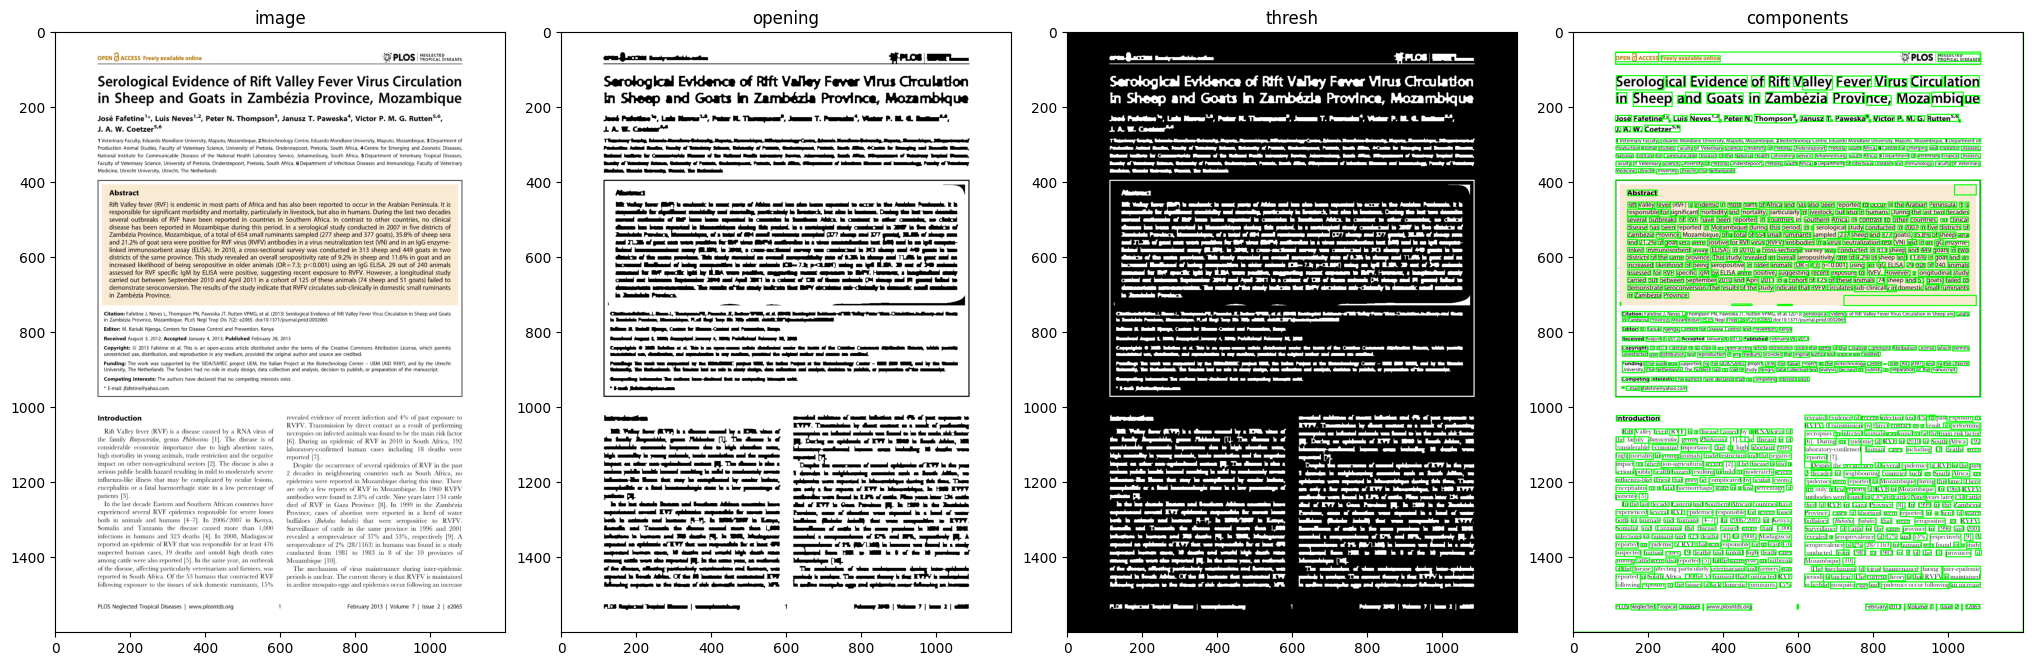

In [17]:
dv.show_docs(count=10)

In [18]:
def test(test_folder):
    qry_files = [file for file in os.listdir(test_folder) if file.endswith('.png')] #filter only image files
    qry_file_paths = [os.path.join(test_folder, file_name) for file_name in qry_files] 
    df = pd.DataFrame(columns=['qry_file_paths','doc_file_paths','return_doc_id','point_matching_path', 'time_taken'])

    for idx,img_path in enumerate(qry_file_paths):
        try:
            start = datetime.datetime.now()
            qry = cv2.imread(img_path)
            qry = preprocess(qry)
            doc_id,doc_path,custom_plot = query(qry,qry_id=idx)   
            end = datetime.datetime.now()
            res = [img_path,doc_id,doc_path,custom_plot, end-start]
            print(res)
            df.loc[len(df)] = pd.Series(res)
        except Exception as e:
            print(idx,img_path,e)
        
    return df

final retreived result document ID: 23
./GT/_17.MP4_10995.png
['./queries/_17.MP4_11206.png', 23, './GT/_17.MP4_10995.png', './results/point_match_0.png', datetime.timedelta(seconds=73, microseconds=605450)]
final retreived result document ID: 46
./GT/12.png
['./queries/_6.mp4_2587.png', 46, './GT/12.png', './results/point_match_0.png', datetime.timedelta(seconds=114, microseconds=707045)]
final retreived result document ID: 42
./GT/_17.MP4_11697.png
['./queries/_17.MP4_11846.png', 42, './GT/_17.MP4_11697.png', './results/point_match_0.png', datetime.timedelta(seconds=82, microseconds=955098)]
final retreived result document ID: 13
./GT/_14.MP4_4820.png
['./queries/_11.mp4_748.png', 13, './GT/_14.MP4_4820.png', './results/point_match_0.png', datetime.timedelta(seconds=27, microseconds=762917)]
final retreived result document ID: 5
./GT/_17.MP4_11230.png
['./queries/_17.MP4_9852.png', 5, './GT/_17.MP4_11230.png', './results/point_match_0.png', datetime.timedelta(seconds=40, microseconds

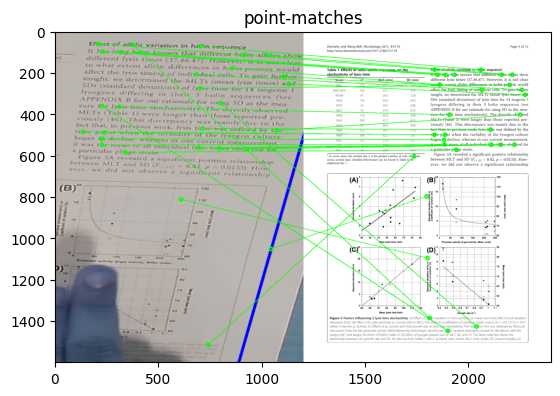

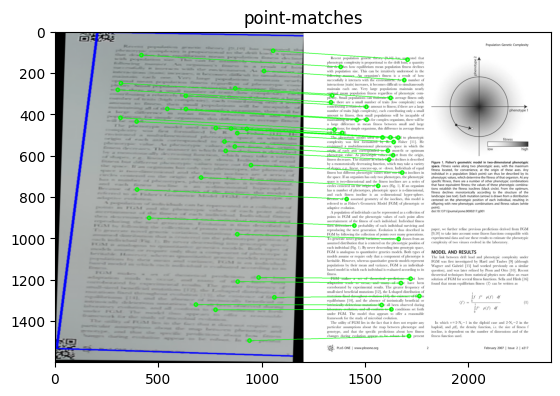

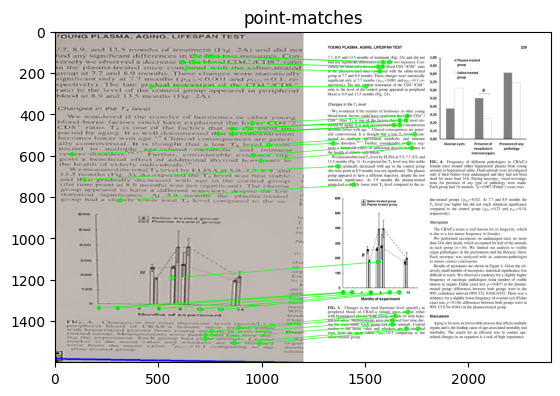

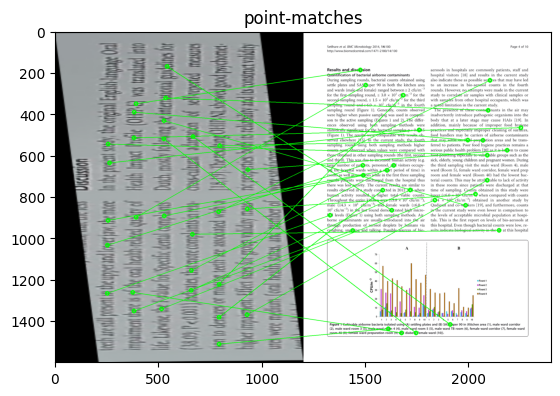

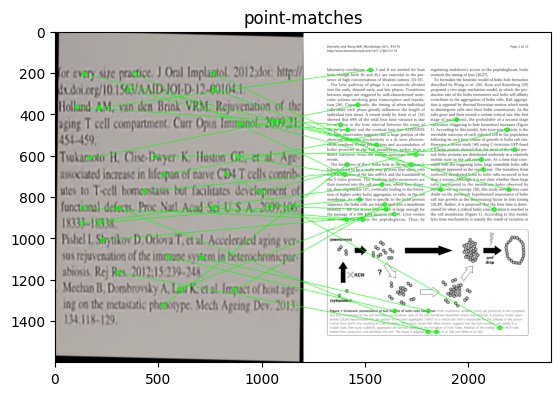

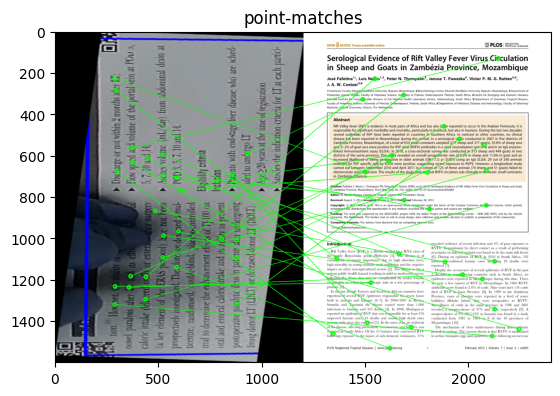

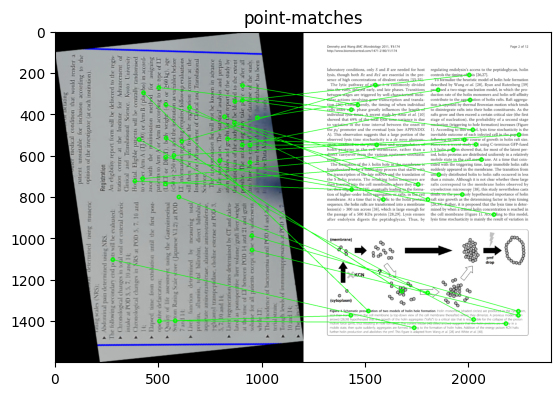

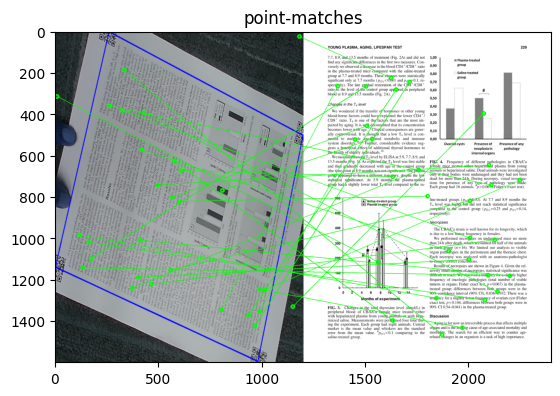

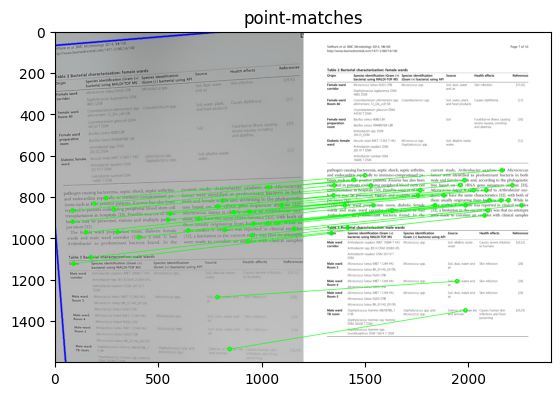

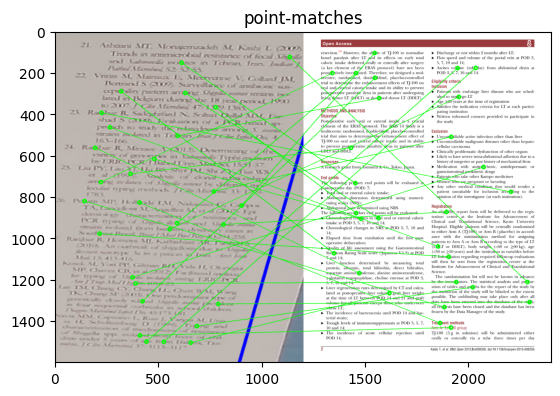

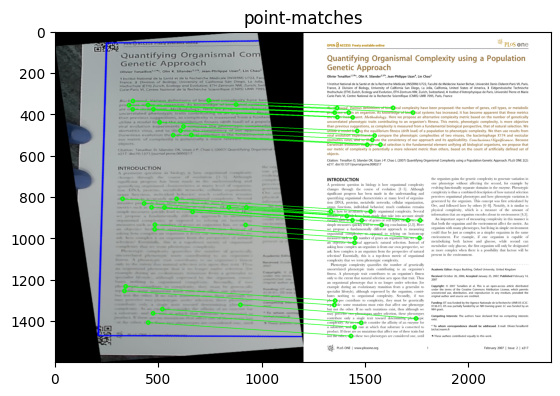

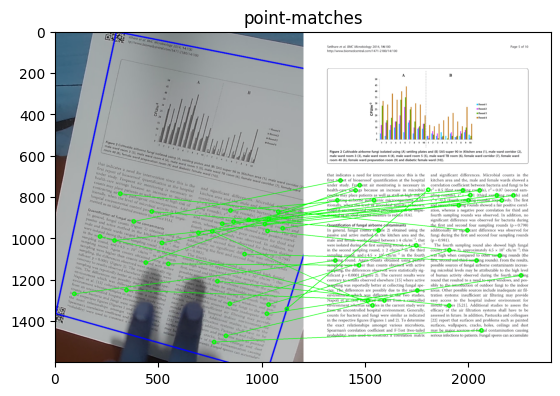

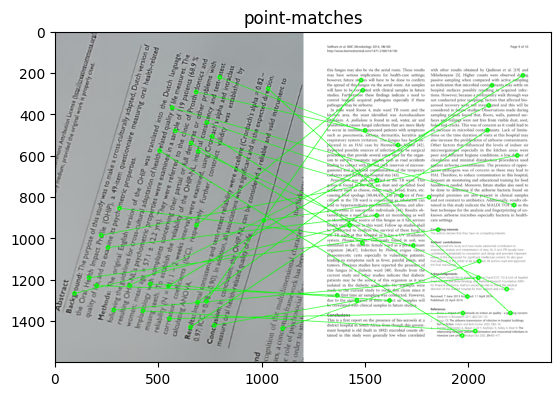

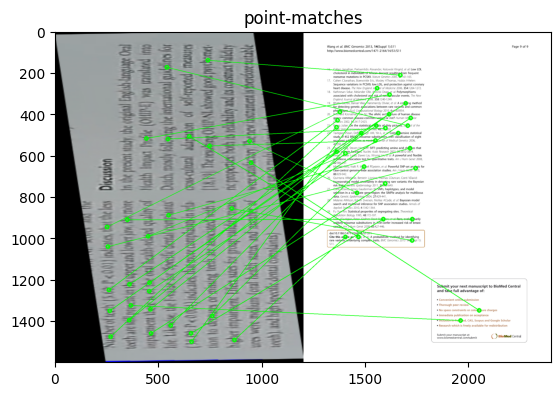

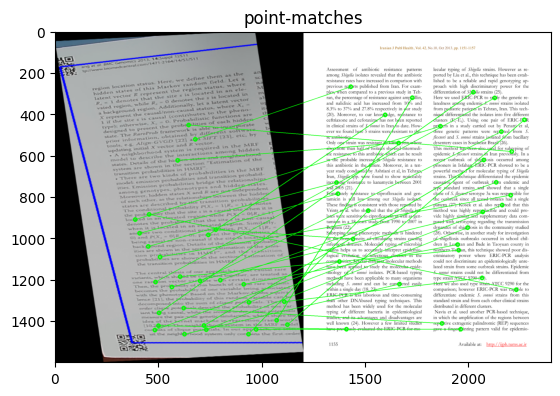

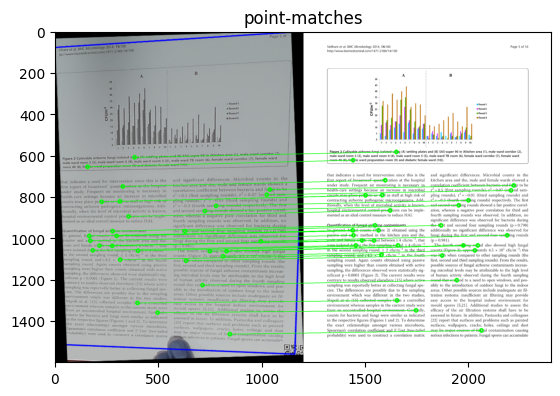

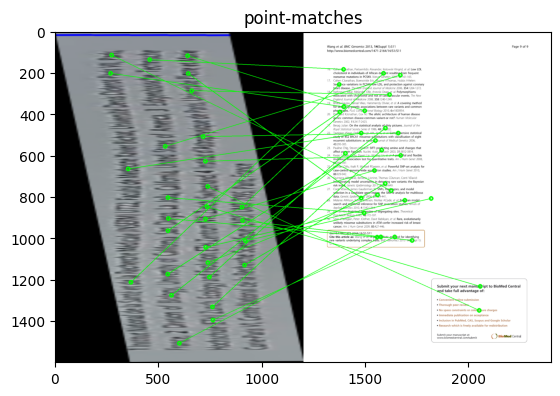

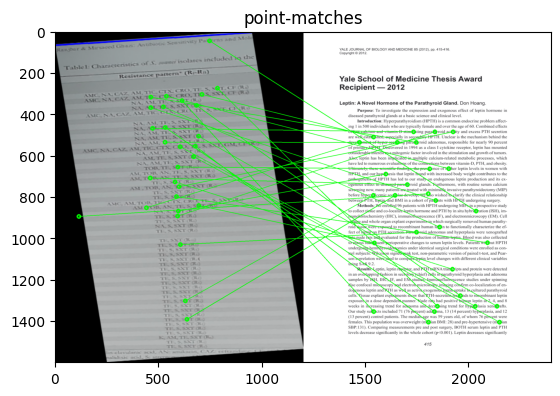

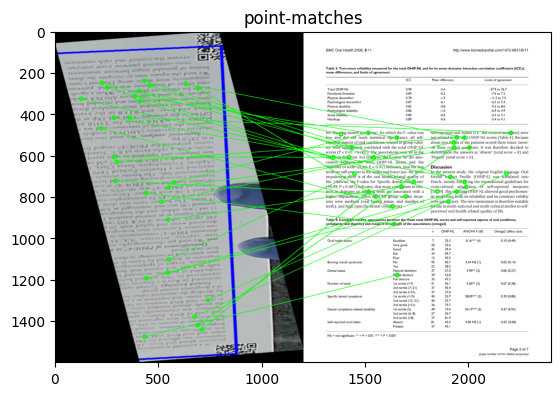

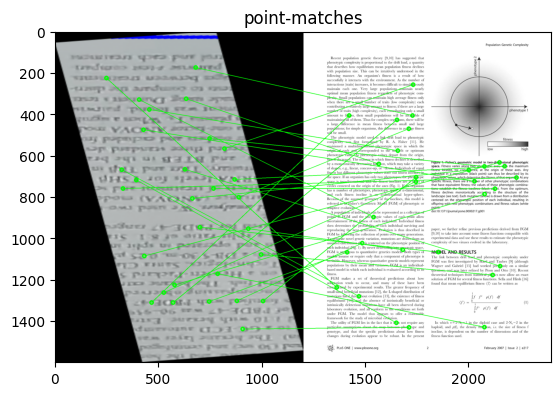

In [20]:
df = test('./queries/')

In [22]:
print(df)

   qry_file_paths doc_file_paths return_doc_id point_matching_path time_taken
0             NaN            NaN           NaN                 NaN        NaN
1             NaN            NaN           NaN                 NaN        NaN
2             NaN            NaN           NaN                 NaN        NaN
3             NaN            NaN           NaN                 NaN        NaN
4             NaN            NaN           NaN                 NaN        NaN
5             NaN            NaN           NaN                 NaN        NaN
6             NaN            NaN           NaN                 NaN        NaN
7             NaN            NaN           NaN                 NaN        NaN
8             NaN            NaN           NaN                 NaN        NaN
9             NaN            NaN           NaN                 NaN        NaN
10            NaN            NaN           NaN                 NaN        NaN
11            NaN            NaN           NaN                 N

In [21]:
df.to_csv('./results/results_df.csv')